# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.
Our target accuracy is 70%, but any accuracy over 50% is a great start.
Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [164]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torchvision.datasets import CIFAR10
from collections import OrderedDict
%config Completer.use_jedi = False

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [206]:
# Define transforms
batch_size = 512
mean = [0.5, 0.5, 0.5]
std = [0.229, 0.224, 0.225]
train_transforms = transforms.Compose([transforms.Resize(320),
                                       transforms.CenterCrop(299),
                                       #transforms.RandomCrop(299, padding=None),
                                       transforms.RandomRotation(45),
                                       transforms.RandomVerticalFlip(),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean,
                                                            std)])

test_valid_transforms = transforms.Compose([transforms.Resize(320),
                                      transforms.CenterCrop(299),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean,
                                                           std)])



# Create training set and define training dataloader

trainset = torchvision.datasets.CIFAR10(root='./dataset', train=True,
                                        download=True, transform=train_transforms)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)

# Create test set and define test dataloader

testset = torchvision.datasets.CIFAR10(root='./dataset', train=False,
                                       download=True, transform=test_valid_transforms)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False)

# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [207]:
int2label_dict = dict(zip(np.array(range(10)),trainset.classes))
train_df = pd.DataFrame(np.vectorize(int2label_dict.get)(np.array(trainset.targets)),
                       columns=['train_labels'])
test_df = pd.DataFrame(np.vectorize(int2label_dict.get)(np.array(testset.targets)),
                       columns=['test_labels'])

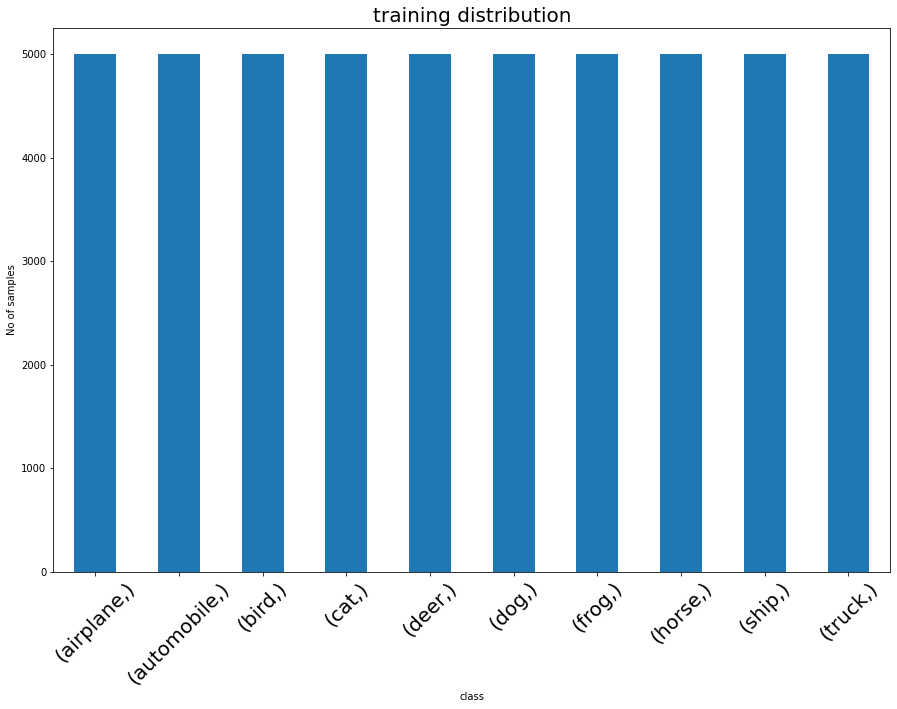

In [208]:
plt.figure(figsize=(15,10))
train_df.value_counts().plot(kind='bar')
plt.title('training distribution', fontsize=20)
plt.xticks(fontsize=20,rotation=45)
plt.xlabel('class')
plt.ylabel('No of samples')
plt.show()

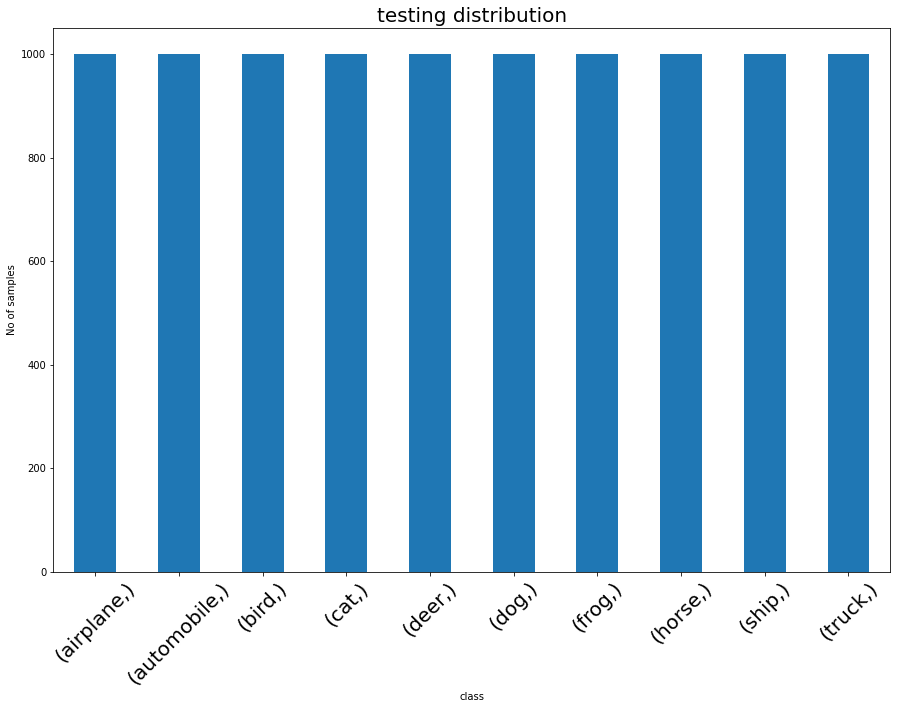

In [209]:
plt.figure(figsize=(15,10))
test_df.value_counts().plot(kind='bar')
plt.title('testing distribution', fontsize=20)
plt.xticks(fontsize=20,rotation=45)
plt.xlabel('class')
plt.ylabel('No of samples')
plt.show()

In [210]:
def show5(img_loader):
    dataiter = iter(img_loader)
    fig = plt.figure(figsize=(15,15))
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):   
        image = images[i].numpy()
        ax = fig.add_subplot(1,5,i+1)
        plt.imshow(np.transpose(image, (1, 2, 0)))
        plt.title(classes[labels[i]])
        plt.xlabel(f"img_shape: {np.transpose(image, (1, 2, 0)).shape}")
        #plt.show()
        
    fig.tight_layout()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


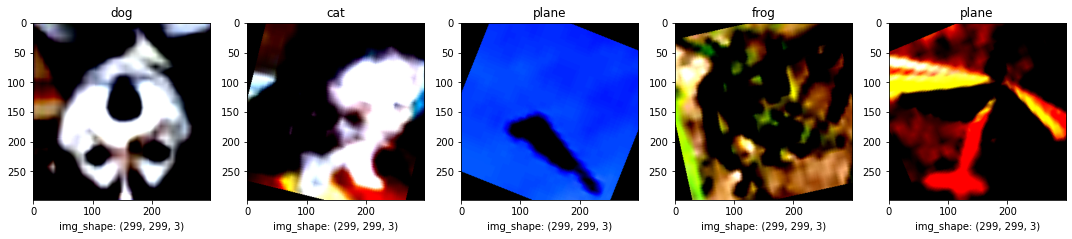

In [211]:
# Explore data
## YOUR CODE HERE ##

show5(trainloader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


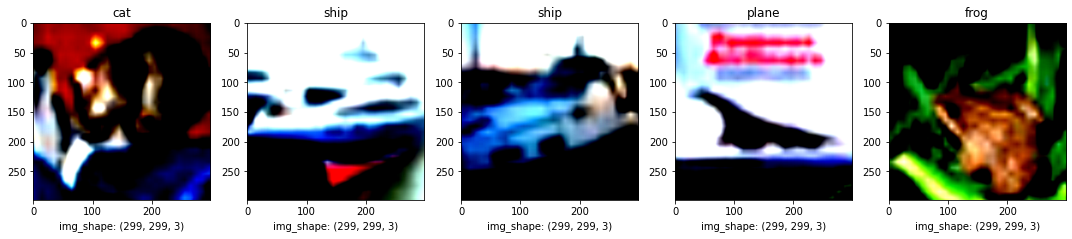

In [212]:
show5(testloader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [213]:
model = models.inception_v3(pretrained=True)
model.aux_logits=False
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

# reclacing the last fully connected layer with a new sequence
fc = nn.Sequential(OrderedDict([
                          ('dropout',nn.Dropout(0.7)),
                          ('relu', nn.ReLU()),
                          ('fc1', nn.Linear(2048, 10,bias=True))]))

    
model.fc = fc
model

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [214]:
## YOUR CODE HERE ##
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [215]:
# Checking if GPU is available
train_on_gpu=torch.cuda.is_available()

if(train_on_gpu):
    print('Training on GPU.')
    device = 'cuda'
else:
    print('No GPU available, training on CPU.')

Training on GPU.


In [219]:
model.to(device)
epochs=3
trainloss_dict = {}
print_every=10
for epoch in range(epochs):
    running_loss = 0
    steps = 0
    for images, labels in trainloader:
        steps += 1
        # Move input and label tensors to the GPU
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = model.forward(images)
        loss = loss_function(logits, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if steps % print_every == 0:
            train_loss = running_loss/print_every
            print(f"Epoch {epoch+1}/{epochs}.. "
            f"step: {steps}/{len(trainloader)}.. "
            f"Train loss: {train_loss:.4f}.. ")
            trainloss_dict[steps/len(trainloader)+epoch]=train_loss
            running_loss = 0

Epoch 1/3.. step: 10/98.. Train loss: 2.0901.. 
Epoch 1/3.. step: 20/98.. Train loss: 2.0110.. 
Epoch 1/3.. step: 30/98.. Train loss: 1.9518.. 
Epoch 1/3.. step: 40/98.. Train loss: 1.9083.. 
Epoch 1/3.. step: 50/98.. Train loss: 1.8948.. 
Epoch 1/3.. step: 60/98.. Train loss: 1.8374.. 
Epoch 1/3.. step: 70/98.. Train loss: 1.8485.. 
Epoch 1/3.. step: 80/98.. Train loss: 1.8516.. 
Epoch 1/3.. step: 90/98.. Train loss: 1.8386.. 
Epoch 2/3.. step: 10/98.. Train loss: 1.7981.. 
Epoch 2/3.. step: 20/98.. Train loss: 1.7961.. 
Epoch 2/3.. step: 30/98.. Train loss: 1.7989.. 
Epoch 2/3.. step: 40/98.. Train loss: 1.7715.. 
Epoch 2/3.. step: 50/98.. Train loss: 1.8120.. 
Epoch 2/3.. step: 60/98.. Train loss: 1.7809.. 
Epoch 2/3.. step: 70/98.. Train loss: 1.7871.. 
Epoch 2/3.. step: 80/98.. Train loss: 1.7779.. 
Epoch 2/3.. step: 90/98.. Train loss: 1.7607.. 
Epoch 3/3.. step: 10/98.. Train loss: 1.7832.. 
Epoch 3/3.. step: 20/98.. Train loss: 1.7785.. 
Epoch 3/3.. step: 30/98.. Train loss: 1.

Plot the training loss (and validation loss/accuracy, if recorded).

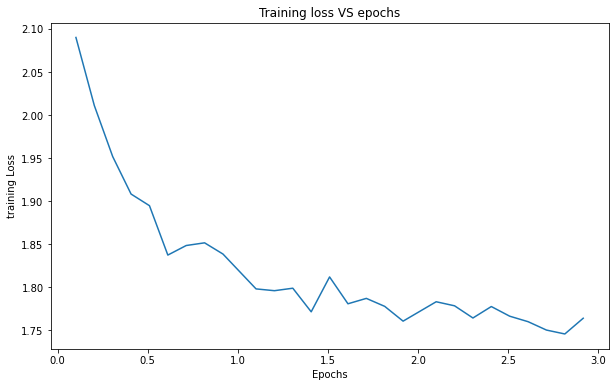

In [231]:
plt.figure(figsize=(10,6))
plt.plot(trainloss_dict.keys(),trainloss_dict.values())
plt.xlabel('Epochs')
plt.ylabel('training Loss')
plt.title('Training loss VS epochs')
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [232]:
def calc_accuracy(model, dataLoader):
    criterion = nn.CrossEntropyLoss()
    accuracy=0
    model.to(device)
    model.eval()
    with torch.no_grad(): 
        valid_loss = 0
        for valid_images, valid_labels in dataLoader:
            valid_images, valid_labels = valid_images.to(device), valid_labels.to(device)
            logits = model.forward(valid_images)
            loss = criterion(logits, valid_labels)
            valid_loss += loss.item()
            _,topClasses=logits.topk(1, dim=1)
            equals=topClasses==valid_labels.view(*topClasses.shape)
            accuracy+=torch.mean(equals.type(torch.FloatTensor)) 
        print(f"Testing loss: {valid_loss/len(dataLoader):.4f}.. "
        f"Testing accuracy: {accuracy/len(dataLoader):.4f}")
        model.train()

In [233]:
calc_accuracy(model, testloader)

Testing loss: 1.5158.. Testing accuracy: 0.5695


## Saving your model
Using `torch.save`, save your model for future loading.

In [235]:
# Save the checkpoint 
checkpoint = {'state_dict': model.state_dict(),
            'fc': model.fc,
            'class_to_idx': trainset.class_to_idx,
            'opt_state': optimizer.state_dict,
            'num_epochs': epochs}

torch.save(checkpoint, 'checkpoint.pth')

## Load model

In [237]:
def load_from_checkpoint(checkpoint_path, cuda=True):
    if cuda:
        checkpoint = torch.load(checkpoint_path, map_location='cuda')
    else:
        checkpoint = torch.load(checkpoint_path, map_location='cpu')
    model = models.inception_v3(pretrained=True)
    model.aux_logits=False
    fc = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(2048, 10,bias=True)),
                                                                ]))
    model.fc = fc
    model.load_state_dict(checkpoint['state_dict'], strict=False)
    for param in model.parameters():
        param.requires_grad = False
    model.eval()
    return model

reloaded_model = load_from_checkpoint('checkpoint.pth', cuda=False)

In [238]:
reloaded_model

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.

**Evaluation:** Based on our current performance in the testingset for CIFAR10 we recommend buying the Detectocorp's computer vision solution as our model reached only 57% contrary to the 70% that the company claims. 

Unless there is more time to fine-tune the algorithm we can think in using our own implementation. Some of the thing that require time, but could potentially increase the performance of our model are the following:

* fine-tunning the hyper-parameters by using a separate validation set. i.e. having a training, validation and testing sets.
* Decrease the learning rate or use a decaying factor
* Try different augmentation techniques
* Use batch normalization.
* Try other architectures to perform transfer learning
